In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge,ElasticNet,Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
train = pd.read_csv(r"c:\train.csv")
test = pd.read_csv(r"c:\test.csv")

## Saleprice分布

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


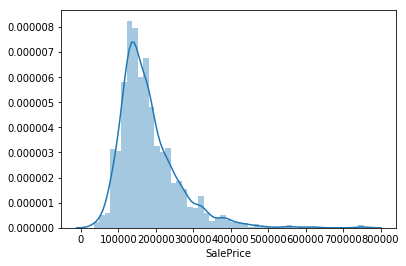

In [3]:
sns.distplot(train.SalePrice)

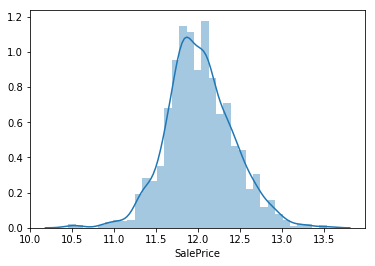

In [4]:
y=np.log(train.SalePrice)
sns.distplot(y)

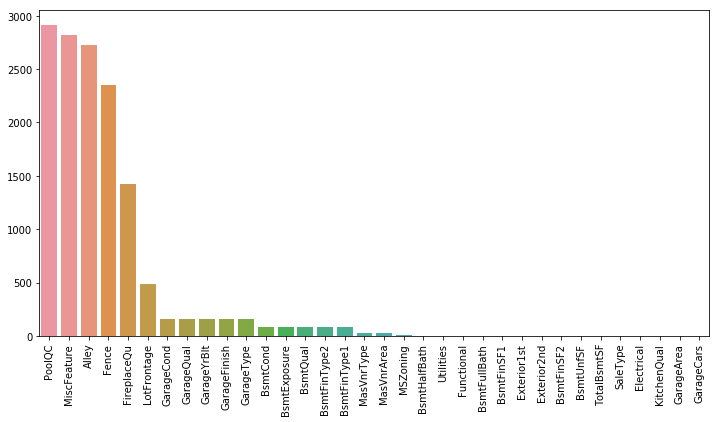

In [5]:
all_data=pd.concat([train.drop('SalePrice',axis=1),test])
all_data_na=all_data.isnull().sum().sort_values(ascending=False)
all_data_na=all_data_na[all_data_na>0]
plt.figure(figsize=(12, 6))
plt.xticks(rotation="90")
sns.barplot(x=all_data_na.index,y=all_data_na.values)

In [6]:
all_data_na

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
Exterior1st        1
Exterior2nd        1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
SaleType           1
Electrical         1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64

大部分缺失特征并非数值缺失而是代表次项目不存在，所以用‘None'或'0,替代。尔MSZoning，Exterior1st，Exterior2nd，Electrical，KitchenQual，Functional，SaleType这几个特征是必有项，不能用'None'代替，所以用众数替代。

In [7]:
all_data['MSZoning']=all_data.fillna(all_data['MSZoning'].mode())
all_data['Exterior1st']=all_data.fillna(all_data['Exterior1st'].mode())
all_data['Exterior2nd']=all_data.fillna(all_data['Exterior2nd'].mode())
all_data['Electrical']=all_data.fillna(all_data['Electrical'].mode())
all_data['KitchenQual']=all_data.fillna(all_data['KitchenQual'].mode())
all_data['Functional']=all_data.fillna(all_data['Functional'].mode())
all_data['SaleType']=all_data.fillna(all_data['SaleType'].mode())

In [8]:
numeric_all_data=all_data.select_dtypes(exclude='object')
categorical_all_data=all_data.select_dtypes(include='object')
for col in numeric_all_data:
    all_data[col].fillna(0.,inplace=True)
for col in categorical_all_data:
    all_data[col].fillna('None',inplace=True)
    

In [9]:
all_data_dummies=pd.get_dummies(all_data)
train_dummies=all_data_dummies.iloc[:train.shape[0]]
test_dummies=all_data_dummies.iloc[train.shape[0]:]

In [10]:
print(train_dummies.shape,y.shape)

(1460, 250) (1460,)


In [11]:
clf=Ridge(alpha=10)
clf.fit(train_dummies,y)
np.sqrt(-cross_val_score(clf,train_dummies,y,cv=5,scoring='neg_mean_squared_error')).mean()

0.14082702182556925

In [12]:
y_pred=clf.predict(train_dummies)

In [13]:
mean_squared_error(y,y_pred)

0.01373343867311499

In [14]:
def rmse(y_true,y_pred):
    diff=y_true-y_pred
    sum_sq=sum(diff**2)
    n=len(y_true)
    return np.sqrt(sum_sq/n)

In [15]:
def residual(y_true,y_pred):
    resid=y_true-y_pred
    mean_resid=resid.mean()
    std_resid=resid.std()
    return (resid-mean_resid)/std_resid

In [16]:
resid = y-y_pred
mean_resid=resid.mean()
std_resid=resid.std()
z=(resid-mean_resid)/std_resid

In [17]:
r=residual(y,y_pred)

In [18]:
outliers1=np.where(abs(r)>3)[0]

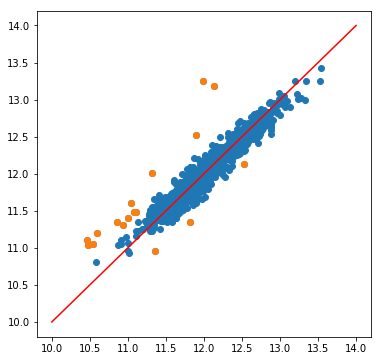

In [19]:
plt.figure(figsize=(6,6))
plt.scatter(y,y_pred)
plt.scatter(y.iloc[outliers1], y_pred[outliers1])
plt.plot(range(10, 15), range(10, 15), color="red")

In [20]:
enr=ElasticNet(alpha=0.001)
enr.fit(train_dummies,y)
pred_y=enr.predict(train_dummies)

In [21]:
r=residual(y,y_pred)
outliers2=np.where(abs(r)>3)[0]

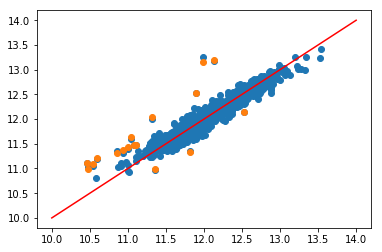

In [22]:
plt.scatter(y,y_pred)
plt.scatter(y.iloc[outliers2],pred_y[outliers2])
plt.plot(range(10, 15), range(10, 15), color="red")


In [23]:
outliers=[]
for i in outliers1:
    for j in outliers2:
        if i==j:
            outliers.append(i)
y=y.drop(outliers)
train_dummies=train_dummies.drop(outliers)

In [24]:
len(outliers)

17

In [25]:
lso=Lasso(alpha=0.005)
lso.fit(train_dummies,y)
np.sqrt(-cross_val_score(lso,train_dummies,y,cv=5,scoring="neg_mean_squared_error")).mean()

0.1144572825957905

In [26]:
rdg=Ridge(alpha=10)
rdg.fit(train_dummies,y)
np.sqrt(-cross_val_score(rdg,train_dummies,y,cv=5,scoring="neg_mean_squared_error")).mean()

0.1024578337518336

In [27]:
en=ElasticNet(alpha=0.01)
en.fit(train_dummies,y)
np.sqrt(-cross_val_score(en,train_dummies,y,cv=5,scoring="neg_mean_squared_error")).mean()

0.11450499577998838

In [28]:
gbr = GradientBoostingRegressor(max_depth=4, n_estimators=150)
gbr.fit(train_dummies,y)
np.sqrt(-cross_val_score(gbr,train_dummies,y,cv=5,scoring='neg_mean_squared_error')).mean()

0.10991130671033147

In [29]:
test_pred=0.3*rdg.predict(test_dummies)+0.3*en.predict(test_dummies)+0.3*gbr.predict(test_dummies)+0.1*lso.predict(test_dummies)

In [30]:
result=pd.DataFrame(np.exp(test_pred))
result.to_csv('sample.csv',index=False)